In [3]:
pip install pandas_ta

     -------------------------------------- 115.1/115.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=d3962343b97484257104d7499b0a5979870d75c71d4bfd80b291f860789c6188
  Stored in directory: c:\users\devra\appdata\local\pip\cache\wheels\1e\5c\47\759b32beb377aee150eb4c1f1b2b7635032cc19ea09ce076fd
Successfully built pandas_ta
Note: you may need to restart the kernel to use updated packages.


DOWNLOAD SP500 STOCKS PRICES DATA

In [35]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-30'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443758400, endDate = 1696046400")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-10-02 A        32.403912   34.669998   34.680000   33.119999   33.180000   
           AAL      36.837147   38.630001   38.770000   37.419998   38.750000   
           AAPL     24.983337   27.594999   27.752501   26.887501   27.002501   
           ABBV     38.779240   55.820000   55.849998   53.720001   53.869999   
           ABT      35.246052   41.380001   41.410000   40.169998   40.250000   
...                       ...         ...         ...         ...         ...   
2023-09-29 XYL      90.469177   91.029999   91.970001   90.480003   91.849998   
           YUM     123.732590  124.940002  125.349998  124.260002  124.830002   
           ZBH     111.996597  112.220001  114.150002  111.769997  113.160004   
           ZBRA    236.529999  236.529999  241.660004  235.970001  238.690002   
           ZTS     173.171677  173.979996  175.589996  173.789993  175.589996   

Price                   volume  
date       ticker               
2015-10-02 A         3519400.0  
           AAL      12276300.0  
           AAPL    232079200.0  
           ABBV      6942600.0  
           ABT       8457500.0  
...                        ...  
2023-09-29 XYL       1833900.0  
           YUM       2610000.0  
           ZBH       1986900.0  
           ZBRA       390000.0  
           ZTS       1498500.0  

[993239 rows x 6 columns]

CALCULATING FEATURES AND TECHNICAL INDICATORS FOR EACH STOCK 
1) Garman-Klass Volatility-the Garman-Klass volatility estimator that uses not only the high and low but also the opening and closing prices.

Garman-Klass (GK) volatility estimator consists of using the returns of the open, high, low, and closing prices in its calculation. 

2)RSI-The Relative Strength Index (RSI), developed by J. Welles Wilder, is a momentum oscillator that measures the speed and change of price movements

3)Bollinger Bands-Bollinger bands help determine whether prices are high or low on a relative basis. They are used in pairs, both upper and lower bands and in conjunction with a moving average. Further, the pair of bands is not intended to be used on its own. Use the pair to confirm signals given with other indicators.

4)Average True Range (ATR) is the average of true ranges over the specified period. ATR measures volatility, taking into account any gaps in the price movement. Typically, the ATR calculation is based on 14 periods, which can be intraday, daily, weekly, or monthly.

5)MACD-Moving average convergence/divergence (MACD) is a technical indicator to help investors identify market entry points for buying or selling

6)Dollar Volume-Dollar volume liquidity is a stock's share price multiplied by its daily share volume. High dollar liquidity makes it easier for institutional traders to buy or sell in large dollar amounts without moving the price substantially.



In [36]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-10-02 A        32.403912   34.669998   34.680000   33.119999   33.180000   
           AAL      36.837147   38.630001   38.770000   37.419998   38.750000   
           AAPL     24.983337   27.594999   27.752501   26.887501   27.002501   
           ABBV     38.779240   55.820000   55.849998   53.720001   53.869999   
           ABT      35.246052   41.380001   41.410000   40.169998   40.250000   
...                       ...         ...         ...         ...         ...   
2023-09-29 XYL      90.469177   91.029999   91.970001   90.480003   91.849998   
           YUM     123.732590  124.940002  125.349998  124.260002  124.830002   
           ZBH     111.996597  112.220001  114.150002  111.769997  113.160004   
           ZBRA    236.529999  236.529999  241.660004  235.970001  238.690002   
           ZTS     173.171677  173.979996  175.589996  173.789993  175.589996   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-10-02 A         3519400.0          0.000843        NaN       NaN   
           AAL      12276300.0         -0.000362        NaN       NaN   
           AAPL    232079200.0         -0.001832        NaN       NaN   
           ABBV      6942600.0         -0.040978        NaN       NaN   
           ABT       8457500.0         -0.006346        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-29 XYL       1833900.0          0.000045  31.698485  4.484801   
           YUM       2610000.0          0.000008  41.585081  4.805202   
           ZBH       1986900.0          0.000181  34.334795  4.717614   
           ZBRA       390000.0          0.000252  39.105533  5.384640   
           ZTS       1498500.0         -0.000021  39.525624  5.143810   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-10-02 A            NaN       NaN       NaN       NaN     114.042326  
           AAL          NaN       NaN       NaN       NaN     452.223865  
           AAPL         NaN       NaN       NaN       NaN    5798.112958  
           ABBV         NaN       NaN       NaN       NaN     269.228749  
           ABT          NaN       NaN       NaN       NaN     298.093483  
...                     ...       ...       ...       ...            ...  
2023-09-29 XYL     4.551556  4.618312 -0.036387 -2.056412     165.911424  
           YUM     4.839716  4.874231  0.265273 -1.465095     322.942059  
           ZBH     4.779904  4.842194 -0.195447 -1.210629     222.526039  
           ZBRA    5.513969  5.643298 -0.023436 -1.453606      92.246700  
           ZTS     5.203267  5.262723  0.565140 -1.533968     259.497757  

[993239 rows x 14 columns]

AGGREGATE TO MONTHLY LEVEL AND FILTER OUT TOP 150 MOST LIQUID STOCKS FOR EACH MONTH.
To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [37]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2015-11-30 A          136.213754   39.086571 -1.039316  3.692471  3.547568   
           AAL        287.915815   39.429935  0.176946  3.827636  3.672028   
           AAPL      4029.441975   26.890560 -0.972241  3.369611  3.282983   
           ABBV       340.716441   40.770767 -0.528275  3.832284  3.735768   
           ABT        212.708765   38.483490 -1.069220  3.704588  3.660875   
...                          ...         ...       ...       ...       ...   
2023-09-30 OTIS       157.725335   79.683983 -1.023056  4.449658  4.369324   
           ABNB      1474.245625  137.210007 -0.956563  5.019864  4.871849   
           CEG        206.984236  108.614395 -0.416315  4.729092  4.671221   
           GEHC       226.644176   67.981949 -0.597523  4.255132  4.164090   
           KVUE       660.828587   19.669571 -1.315534  3.150113  3.010456   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2015-11-30 A       3.620020         -0.001902  0.561562  73.455702  
           AAL     3.749832         -0.000966 -0.512197  40.949379  
           AAPL    3.326297         -0.003209 -0.130828  55.276537  
           ABBV    3.784026         -0.056745  0.231317  48.327814  
           ABT     3.682732         -0.010572  0.343086  55.606788  
...                     ...               ...       ...        ...  
2023-09-30 OTIS    4.409491         -0.000001 -1.500028  38.542663  
           ABNB    4.945856          0.000563 -0.061454  50.809859  
           CEG     4.700156          0.000112  0.152434  55.367607  
           GEHC    4.209611          0.000183 -0.650435  47.307659  
           KVUE    3.080284         -0.000235 -1.629316  32.482632  

[46892 rows x 9 columns]

Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [38]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-10-31 AAL      39.134331  0.407093  3.706314  3.604673  3.655494   
           AAPL     26.248022 -1.041484  3.353305  3.295542  3.324423   
           ABBV     40.620979 -0.894846  3.870876  3.762525  3.816700   
           ABT      34.463539 -1.036910  3.660400  3.559438  3.609919   
           ACN     103.970642 -0.999434  4.664445  4.641169  4.652807   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      52.932461 -0.024304  4.023249  3.988627  4.005938   
           XOM     115.441681  0.874190  4.777917  4.714389  4.746153   
           MRNA    103.290001 -0.550946  4.757012  4.574468  4.665740   
           UBER     45.990002 -0.754266  3.916286  3.804328  3.860307   
           ABNB    137.210007 -0.956563  5.019864  4.871849  4.945856   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-10-31 AAL            -0.000176  1.145127  62.203545  
           AAPL           -0.002384 -0.193032  49.891001  
           ABBV           -0.044217 -0.761803  27.477740  
           ABT            -0.006968 -0.645114  38.008871  
           ACN            -0.004320 -0.132915  53.823625  
...                             ...       ...        ...  
2023-09-30 WMT             0.000032  0.033154  46.929491  
           XOM            -0.000160  1.569613  58.863411  
           MRNA            0.000473 -0.356266  45.204540  
           UBER            0.000162 -0.113048  50.993000  
           ABNB            0.000563 -0.061454  50.809859  

[12516 rows x 8 columns]

Calculate Monthly Returns for different time horizons as features.

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [39]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-10-31 AAL      45.534168  1.015159  3.994389  3.849110  3.921750   
           AAPL     39.767761 -0.909451  3.689796  3.596049  3.642922   
           ABBV     68.121452  0.374007  4.298592  4.205859  4.252226   
           ABT      48.733883 -1.041733  3.944558  3.897414  3.920986   
           ACN     129.900772 -0.989141  4.885869  4.806507  4.846188   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      52.932461 -0.024304  4.023249  3.988627  4.005938   
           XOM     115.441681  0.874190  4.777917  4.714389  4.746153   
           MRNA    103.290001 -0.550946  4.757012  4.574468  4.665740   
           UBER     45.990002 -0.754266  3.916286  3.804328  3.860307   
           ABNB    137.210007 -0.956563  5.019864  4.871849  4.945856   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-10-31 AAL            -0.000363 -0.011854  41.051796  -0.014108   
           AAPL           -0.000998 -0.036638  69.196637   0.096807   
           ABBV           -0.031904  0.471553  55.247880   0.022728   
           ABT            -0.004755  0.280101  53.844929   0.021276   
           ACN            -0.003628  0.354786  69.365292   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 WMT             0.000032  0.033154  46.929491  -0.016481   
           XOM            -0.000160  1.569613  58.863411   0.057469   
           MRNA            0.000473 -0.356266  45.204540  -0.086495   
           UBER            0.000162 -0.113048  50.993000  -0.026254   
           ABNB            0.000563 -0.061454  50.809859   0.043025   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 WMT      0.001995   0.006989   0.014874   0.014754    0.018902  
           XOM      0.051383   0.033937   0.014528   0.009869    0.027894  
           MRNA    -0.063054  -0.052686  -0.063975  -0.059626   -0.011208  
           UBER    -0.035717   0.021317   0.063981   0.071366    0.047012  
           ABNB    -0.050489   0.023005   0.016469   0.053165    0.022514  

[10341 rows x 14 columns]

Download Fama-French Factors and Calculate Rolling Factor Betas.

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [40]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.001722
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.073471
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.010414
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.016481
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.057469

[10341 rows x 6 columns]

Filter out stocks with less than 10 months of data

In [41]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data



Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.001722
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.073471
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.010414
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.016481
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.057469

[10302 rows x 6 columns]

Calculate Rolling Factor Betas

In [42]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.465079 -0.431678 -0.333868 -0.084984  0.831366
           VZ      0.345308 -0.144846  0.236345  0.302245  0.152348
           WFC     1.117865  0.294142  2.071040 -0.436999 -1.531496
           WMT     0.712616 -0.295775 -0.442982 -0.150646  0.551790
           XOM     0.975481 -1.106958  1.776449 -0.635713 -0.397296

[10302 rows x 5 columns]

Joining the rolling factors data to the main features dataframe.

In [43]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10090 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10090 non-null  float64
 1   bb_high           10090 non-null  float64
 2   bb_low            10090 non-null  float64
 3   bb_mid            10090 non-null  float64
 4   garman_klass_vol  10090 non-null  float64
 5   macd              10090 non-null  float64
 6   rsi               10090 non-null  float64
 7   return_1m         10090 non-null  float64
 8   return_2m         10090 non-null  float64
 9   return_3m         10090 non-null  float64
 10  return_6m         10090 non-null  float64
 11  return_9m         10090 non-null  float64
 12  return_12m        10090 non-null  float64
 13  Mkt-RF            10090 non-null  float64
 14  SMB               10090 non-null  float64
 15  HML       

WHAT IS KMEANS CLUSTERING?

Kmeans Clustering is anUnsupervised Machine Learning is the process of teaching a computer to use unlabeled, unclassified data and enabling the algorithm to operate on that data without supervision. Without any previous data training, the machine’s job in this case is to organize unsorted data according to parallels, patterns, and variations. 



For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
K-Means Clustering
You may want to initialize predefined centroids for each cluster based on your research.

For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

Then we will pre-define our centroids for each cluster.

In [50]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data


atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.015159  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.909451  3.689796  3.596049  3.642922         -0.000998   
           ABBV    0.374007  4.298592  4.205859  4.252226         -0.031904   
           ABT    -1.041733  3.944558  3.897414  3.920986         -0.004755   
           ACN    -0.989141  4.885869  4.806507  4.846188         -0.003628   
...                     ...       ...       ...       ...               ...   
2023-09-30 WFC    -0.707289  3.783874  3.696956  3.740415         -0.000030   
           WMT    -0.024304  4.023249  3.988627  4.005938          0.000032   
           XOM     0.874190  4.777917  4.714389  4.746153         -0.000160   
           MRNA   -0.550946  4.757012  4.574468  4.665740          0.000473   
           UBER   -0.754266  3.916286  3.804328  3.860307          0.000162   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.011854  41.051796  -0.014108   0.022981  -0.023860   
           AAPL   -0.036638  69.196637   0.096807   0.015249   0.044955   
           ABBV    0.471553  55.247880   0.022728   0.098590   0.091379   
           ABT     0.280101  53.844929   0.021276   0.034308   0.034801   
           ACN     0.354786  69.365292   0.064180   0.048455   0.037203   
...                     ...        ...        ...        ...        ...   
2023-09-30 WFC    -0.452474  42.307799  -0.010414  -0.055487  -0.011858   
           WMT     0.033154  46.929491  -0.016481   0.001995   0.006989   
           XOM     1.569613  58.863411   0.057469   0.051383   0.033937   
           MRNA   -0.356266  45.204540  -0.086495  -0.063054  -0.052686   
           UBER   -0.113048  50.993000  -0.026254  -0.035717   0.021317   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275750 -0.271695   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362282   
           ABT      0.038672   0.031320    0.029294  0.828092 -0.199020   
           ACN      0.028692   0.027398    0.018728  1.199047 -0.166702   
...                      ...        ...         ...       ...       ...   
2023-09-30 WFC      0.017586   0.001276    0.003686  1.137640  0.314483   
           WMT      0.014874   0.014754    0.018902  0.740055 -0.261890   
           XOM      0.014528   0.009869    0.027894  1.005968 -1.051369   
           MRNA    -0.063975  -0.059626   -0.011208  1.155154  0.762525   
           UBER     0.063981   0.071366    0.047012  1.078922  1.162540   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563294        1  
           AAPL   -0.591145  0.647780  0.458077        3  
           ABBV   -0.033102  0.241981  0.164919        2  
           ABT    -0.529385  0.252407  0.970213        2  
           ACN    -0.328213  0.267788  0.168881        3  
...                     ...       ...       ...      ...  
2023-09-30 WFC     2.009072 -0.404338 -1.468837        1  
           WMT    -0.522678 -0.126426  0.642627        3  
           XOM     1.707833 -0.675679 -0.284025        2  
           MRNA   -1.165677  0.590306  0.993548        3  
           UBER   -0.257003 -1.482231 -0.450323        3  

[10090 rows x 19 columns]

In [51]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

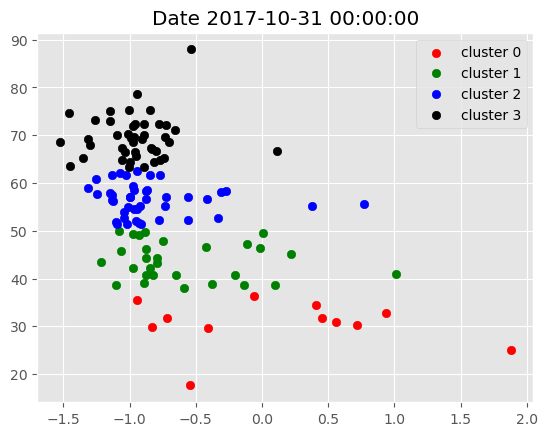

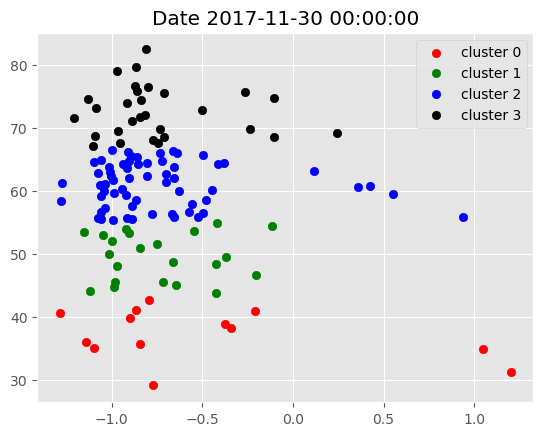

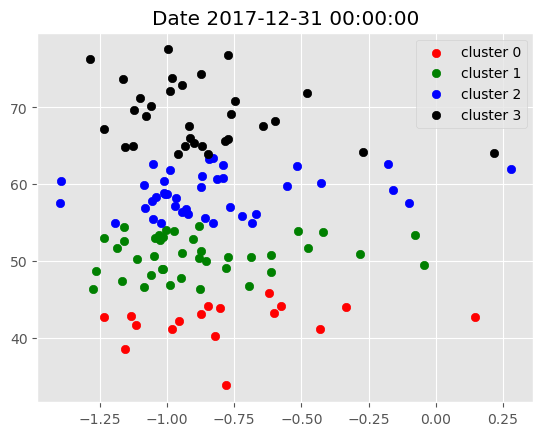

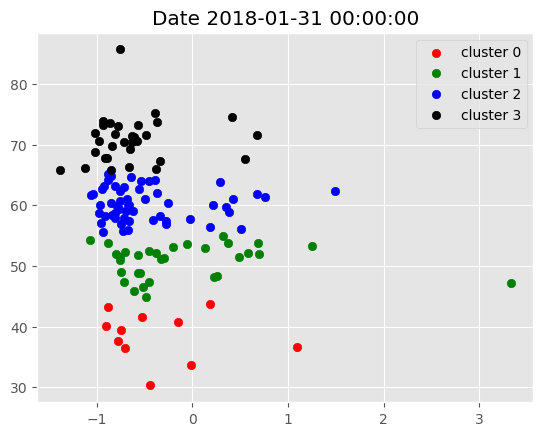

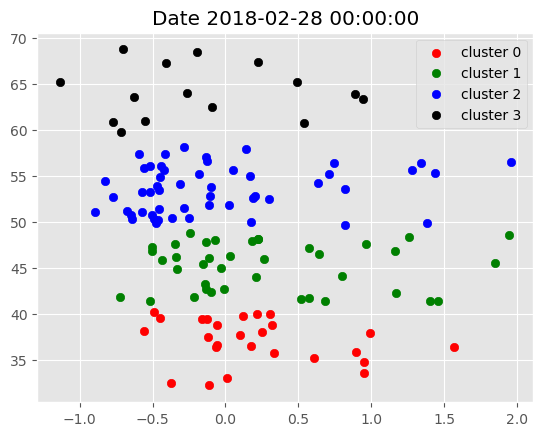

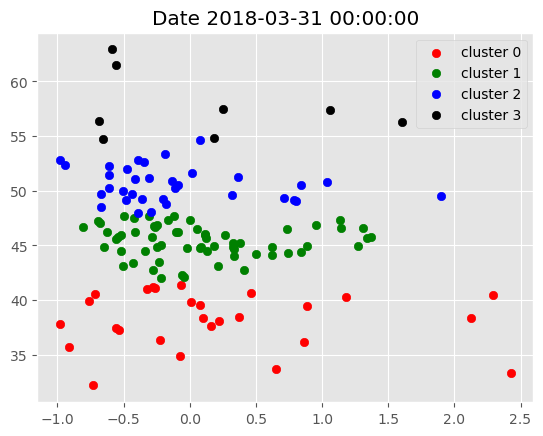

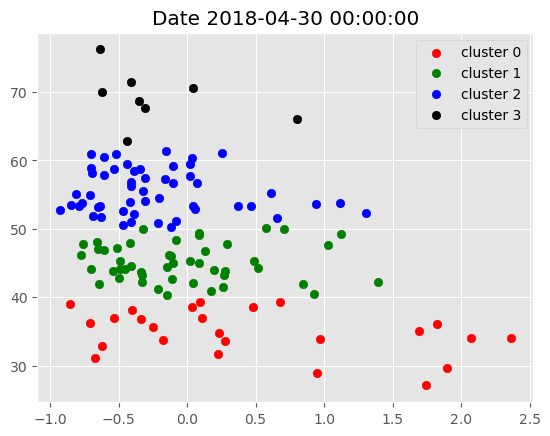

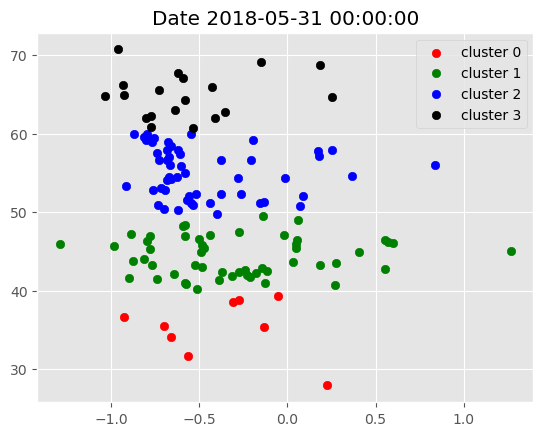

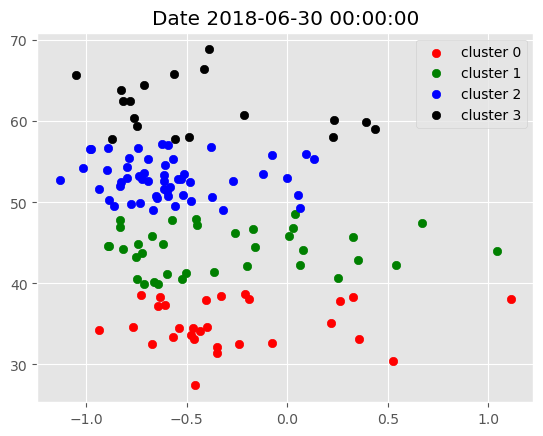

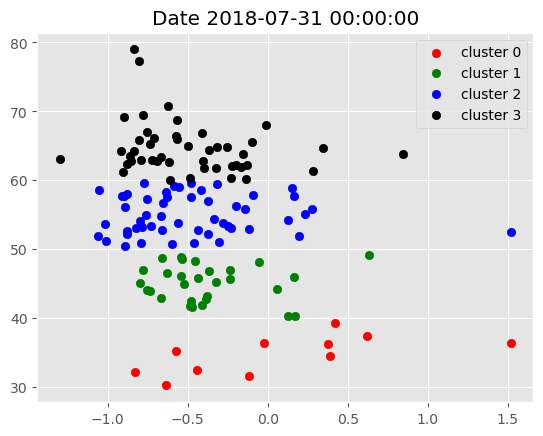

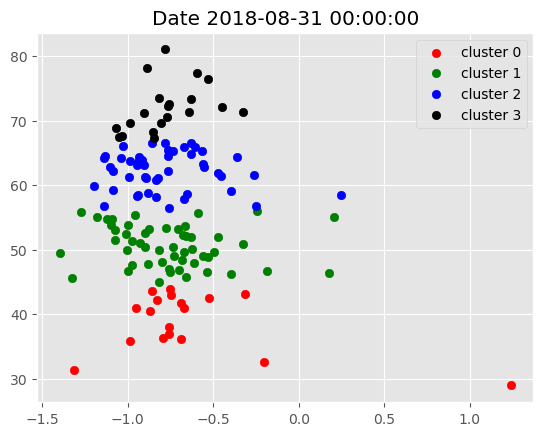

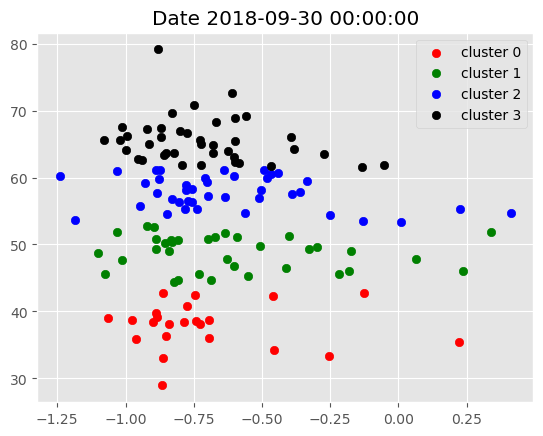

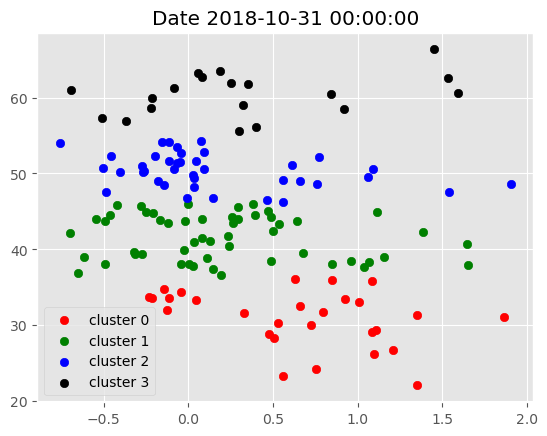

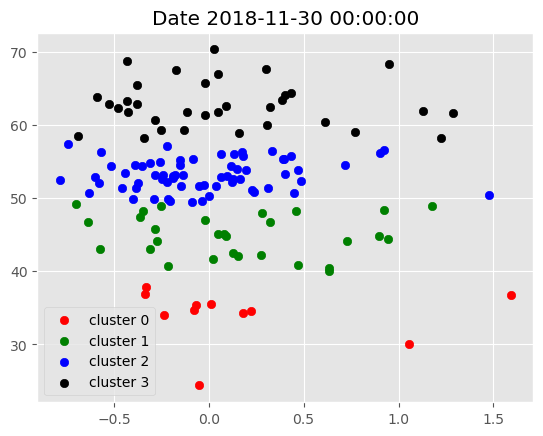

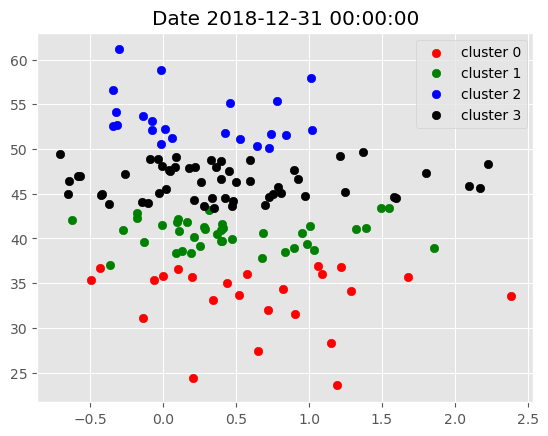

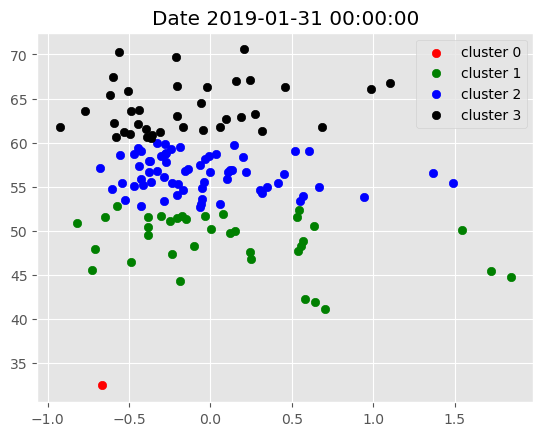

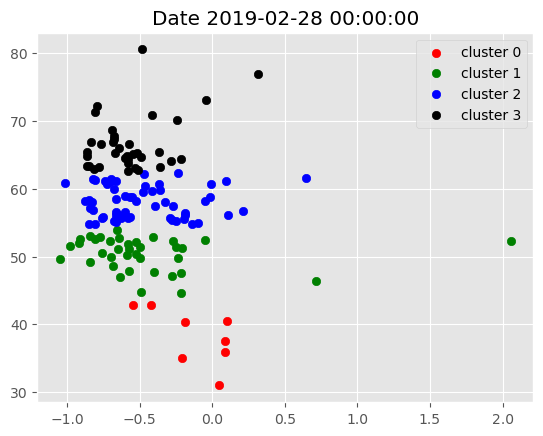

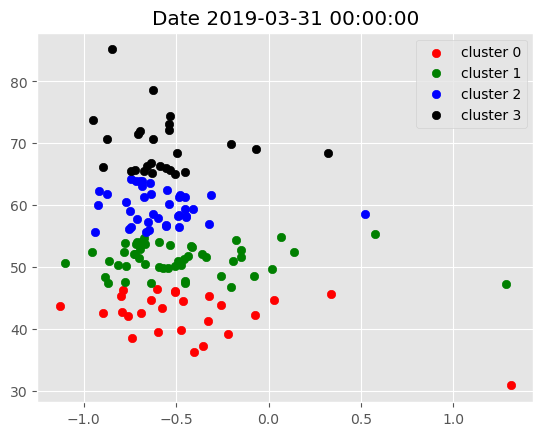

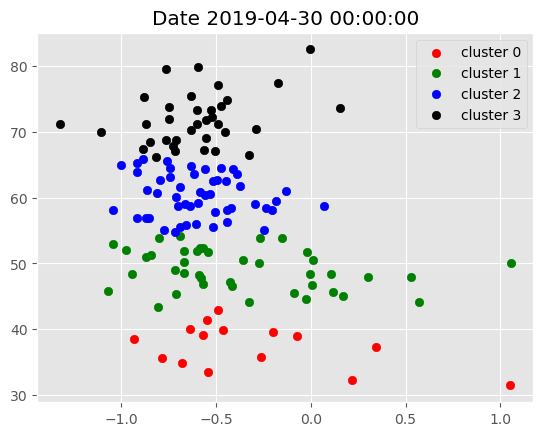

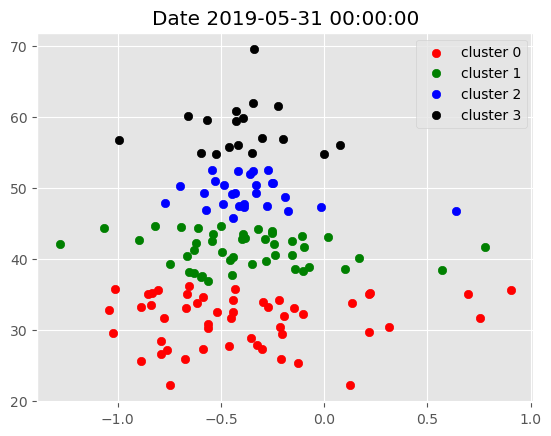

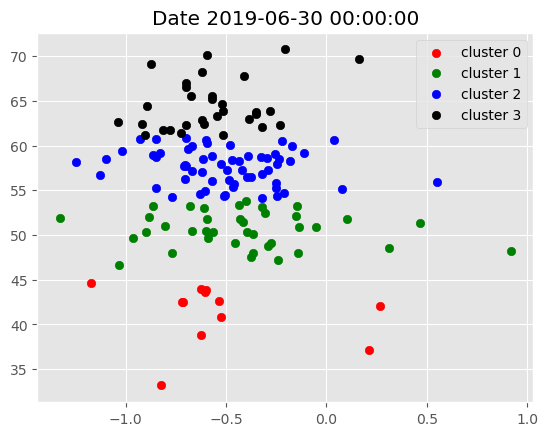

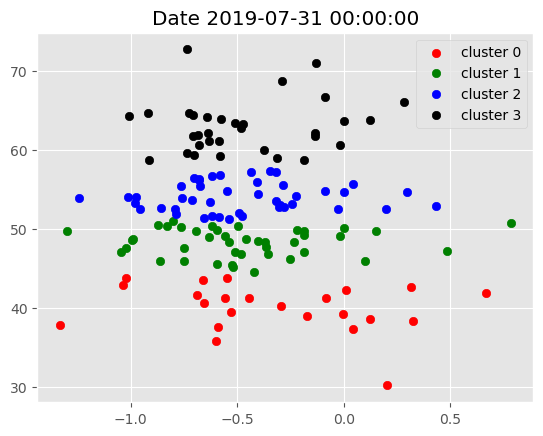

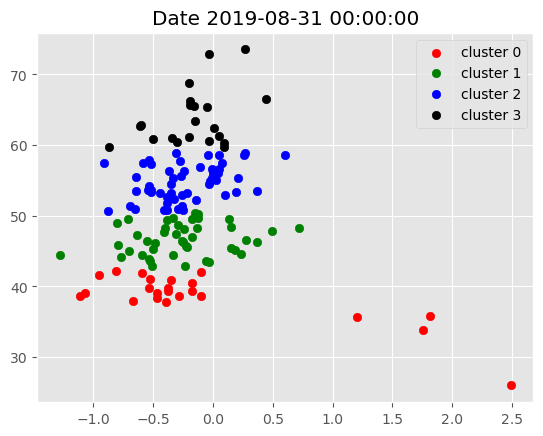

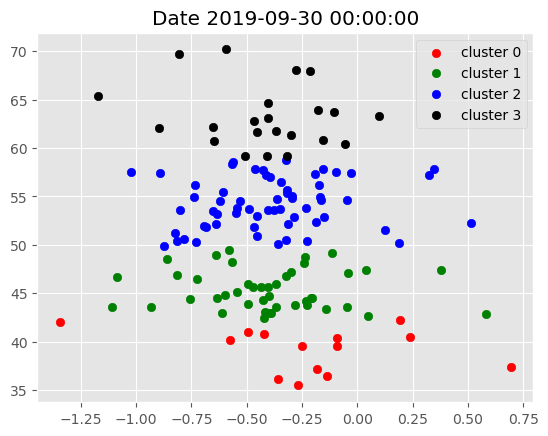

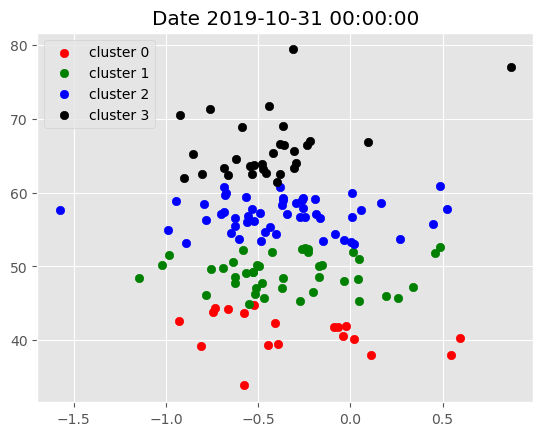

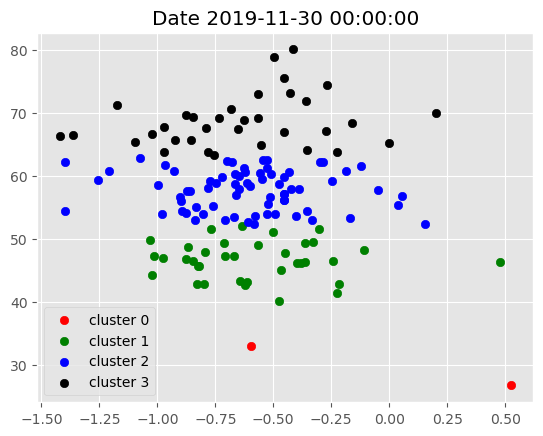

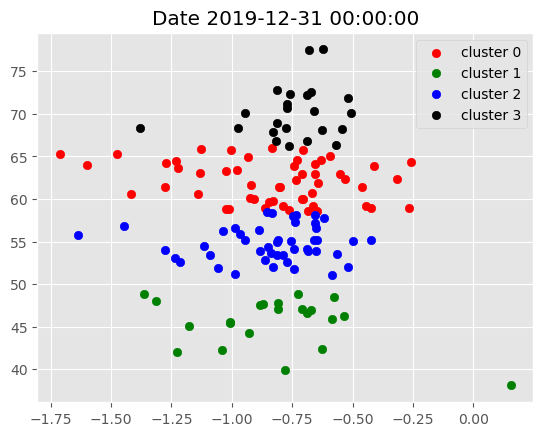

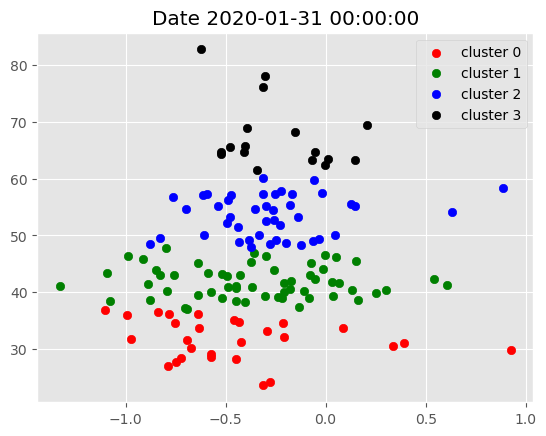

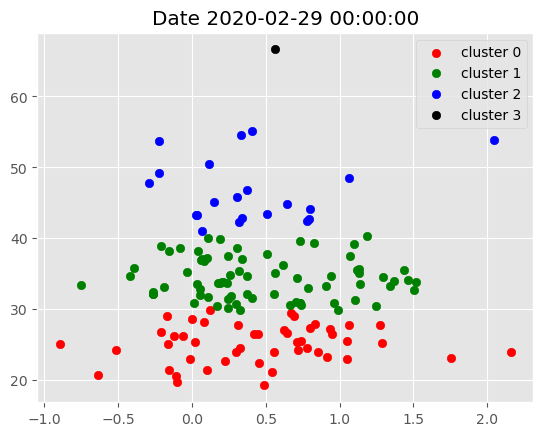

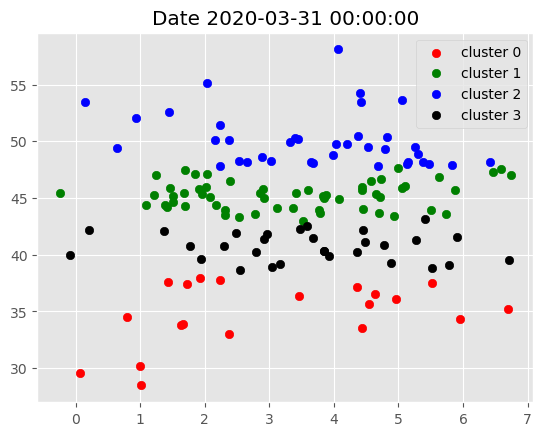

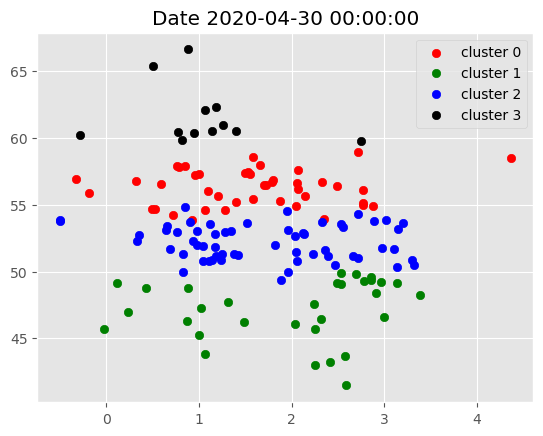

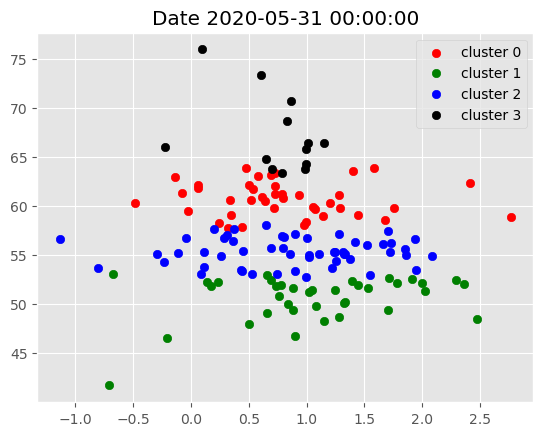

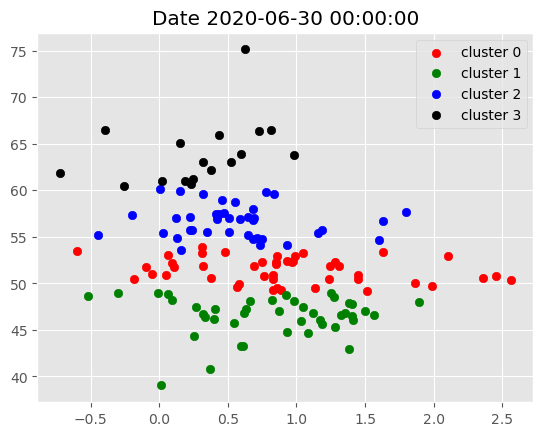

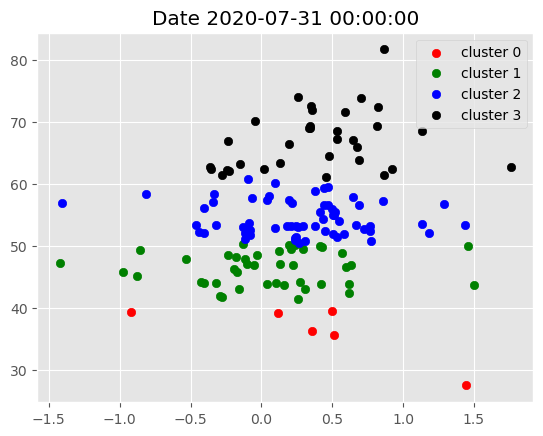

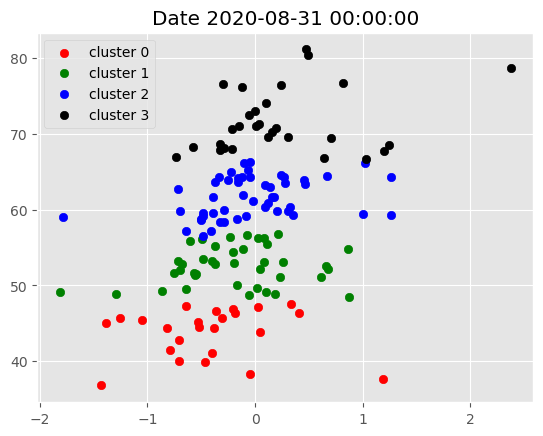

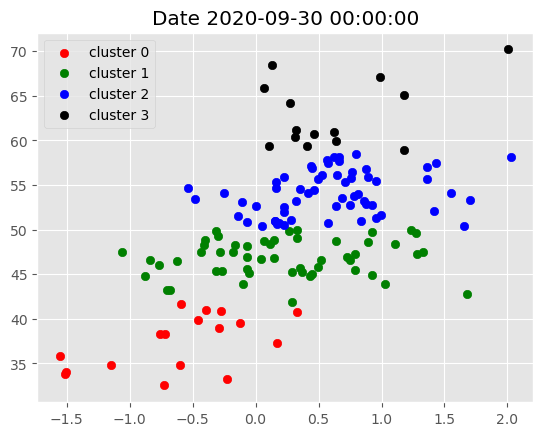

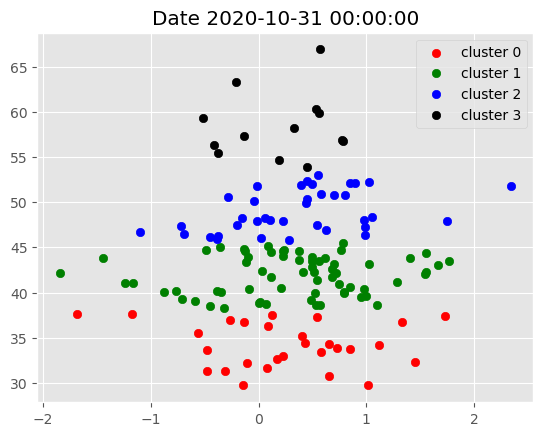

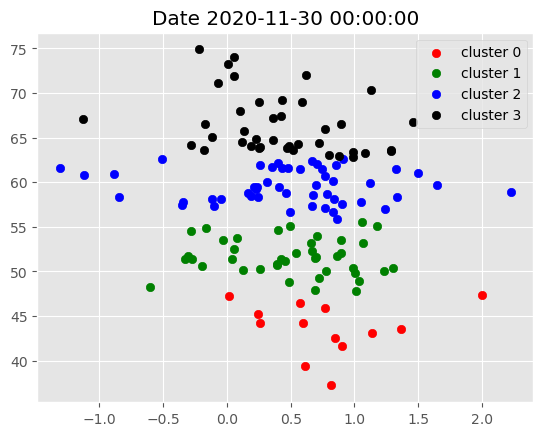

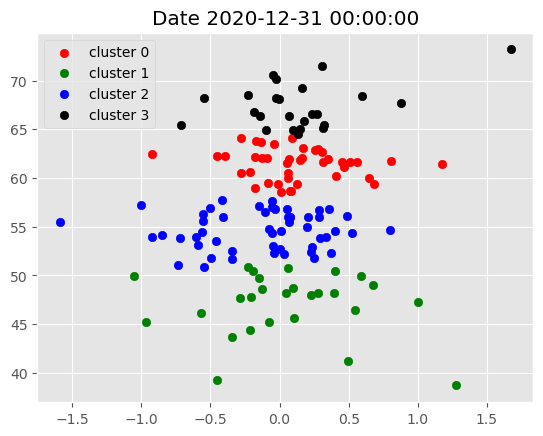

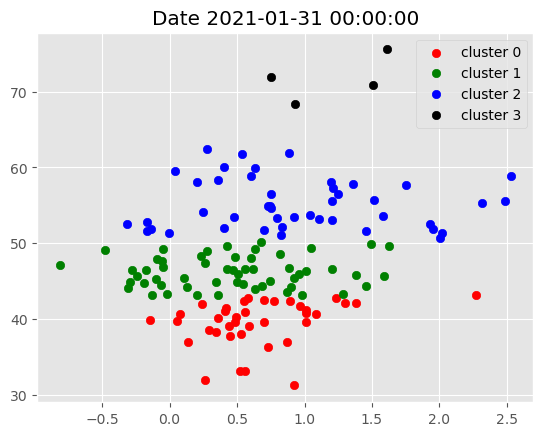

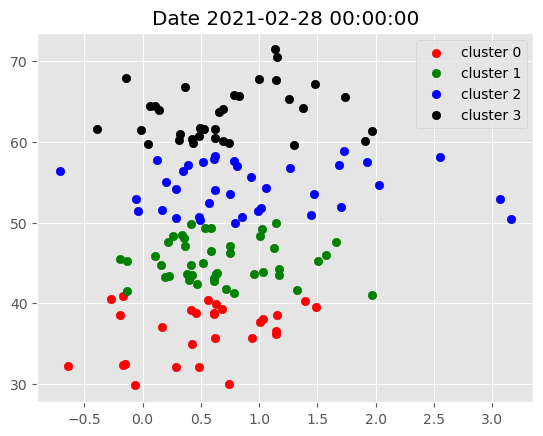

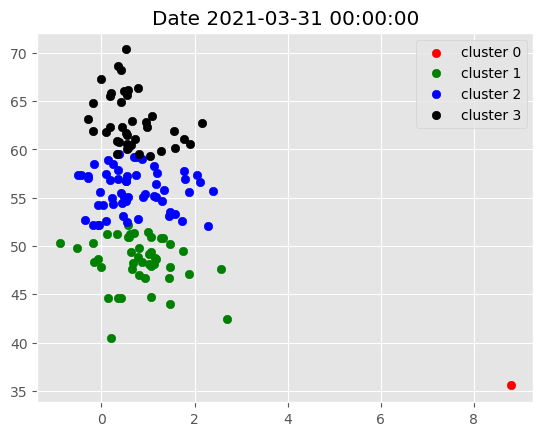

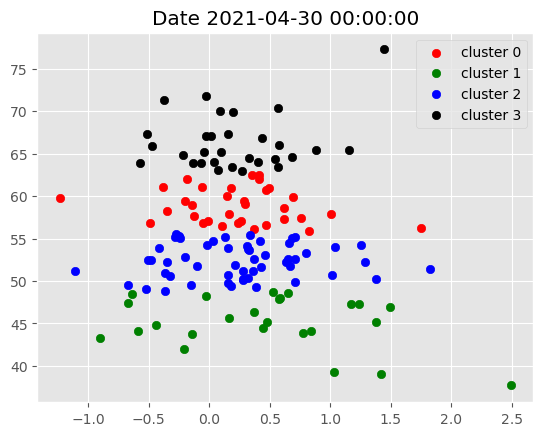

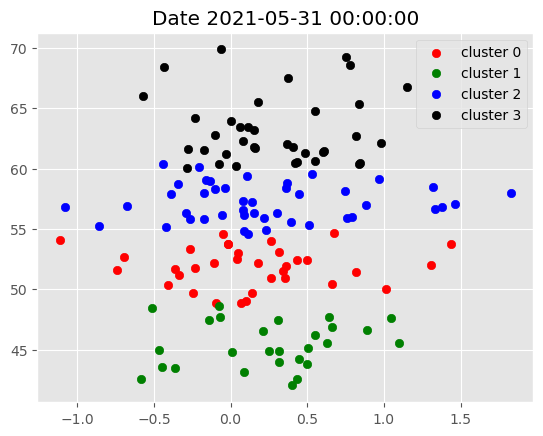

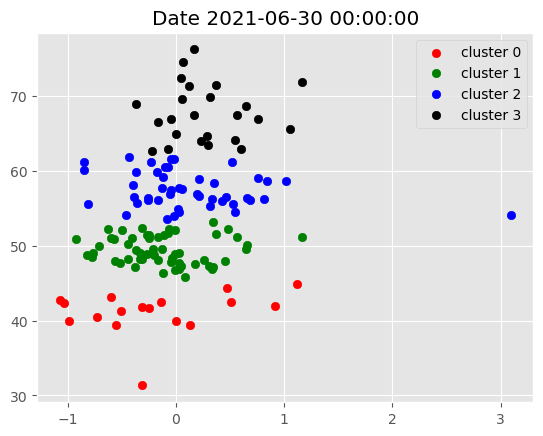

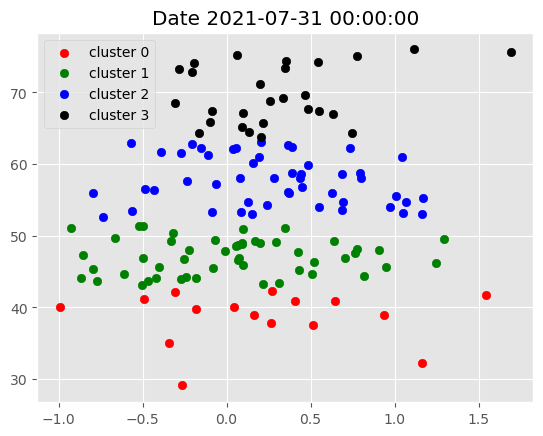

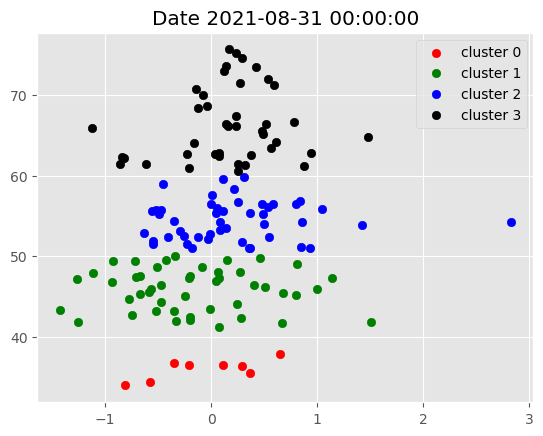

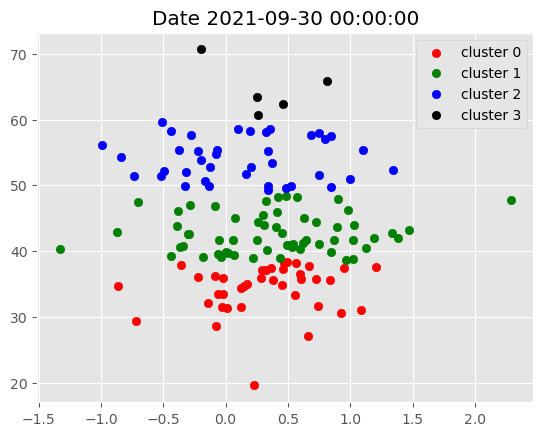

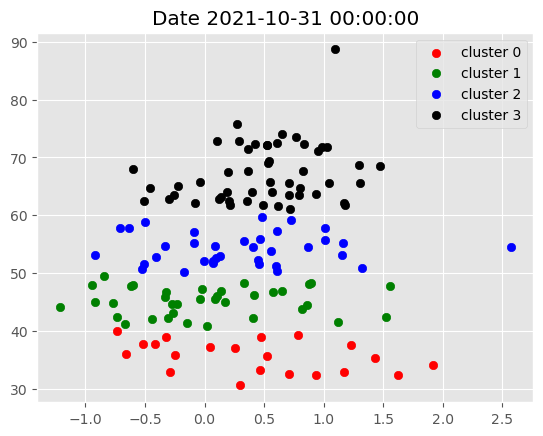

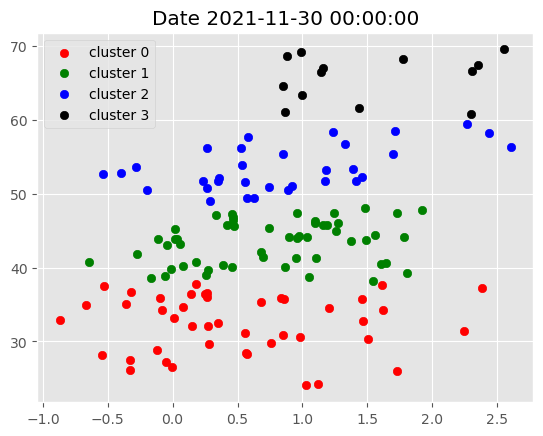

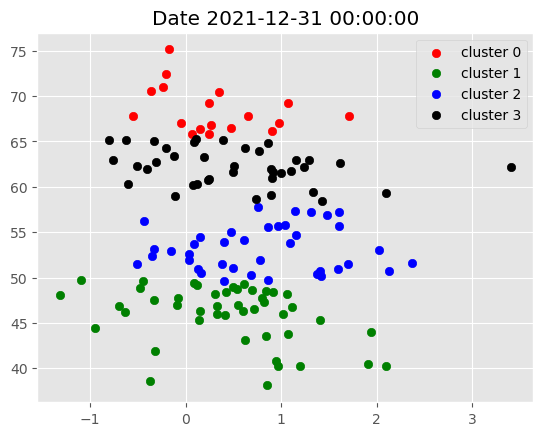

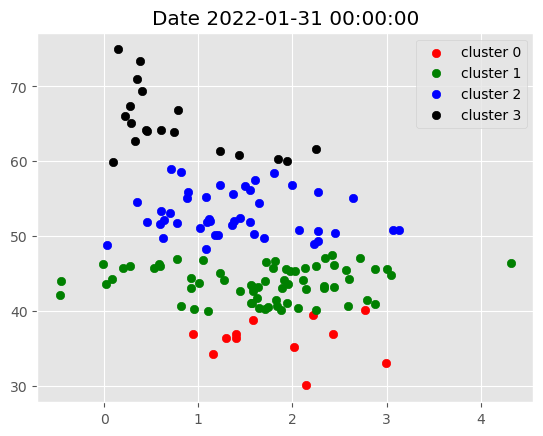

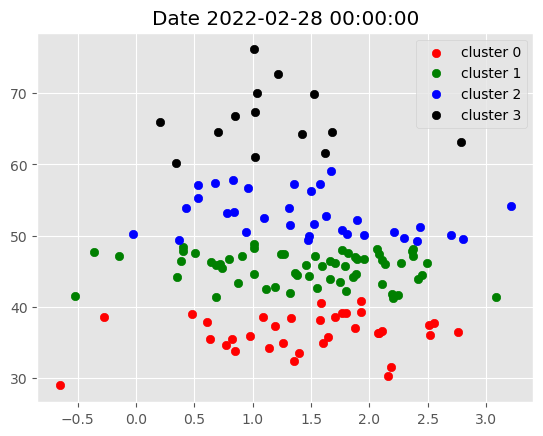

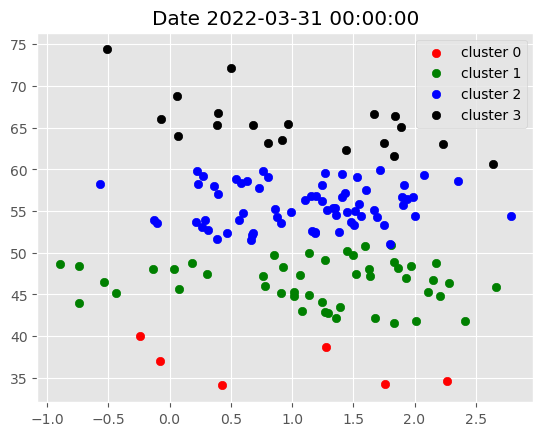

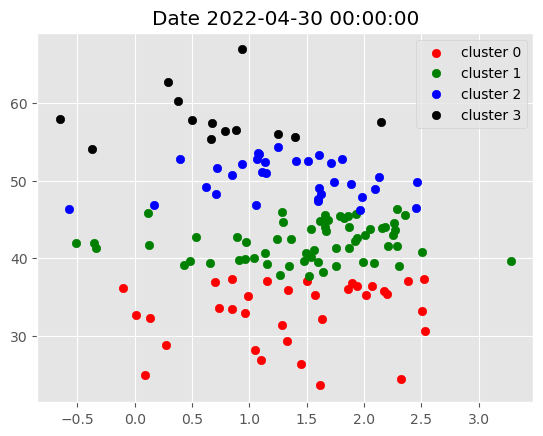

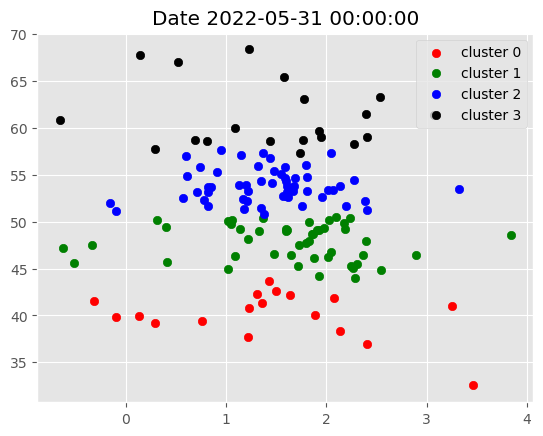

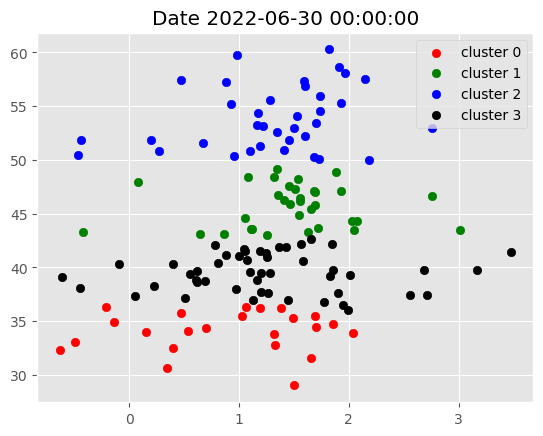

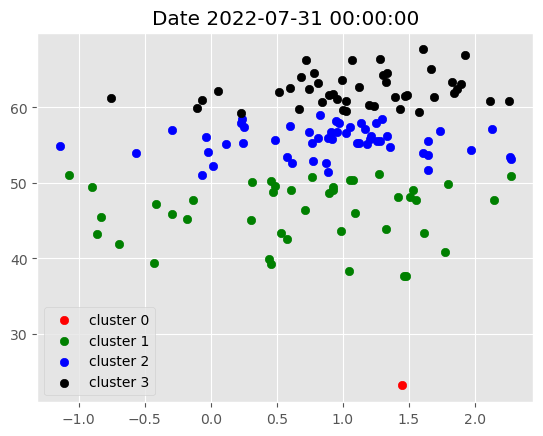

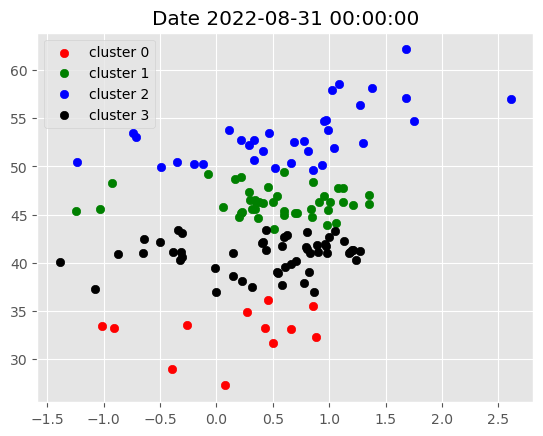

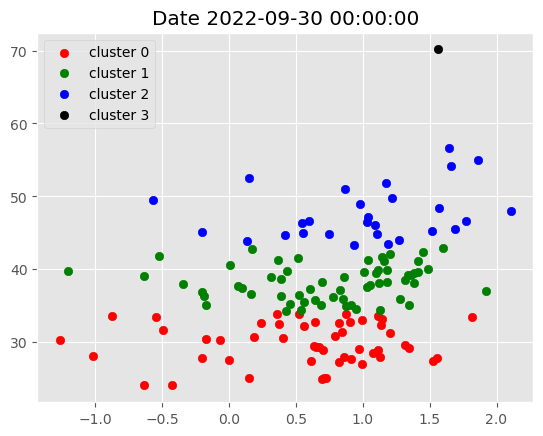

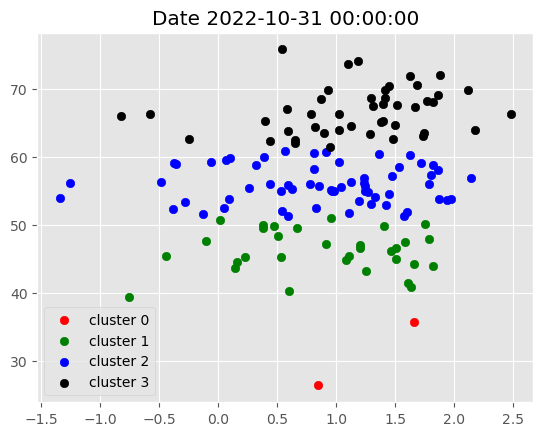

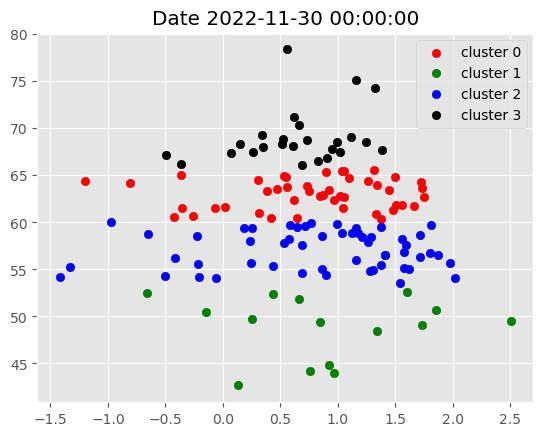

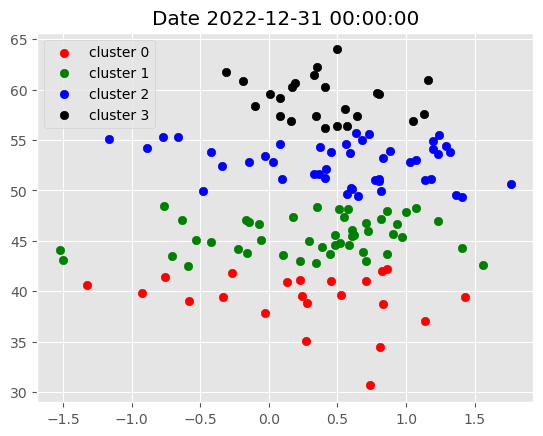

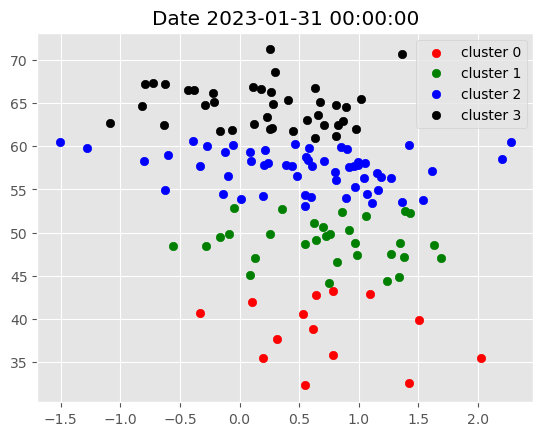

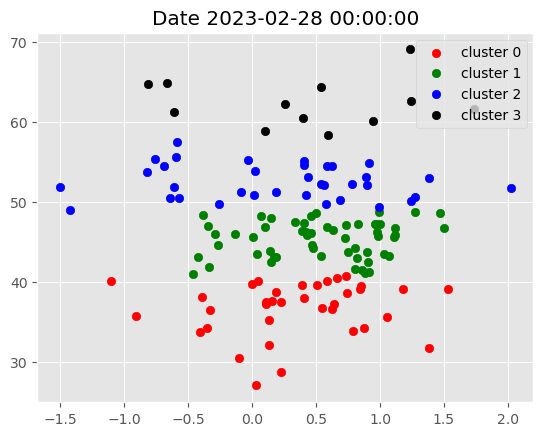

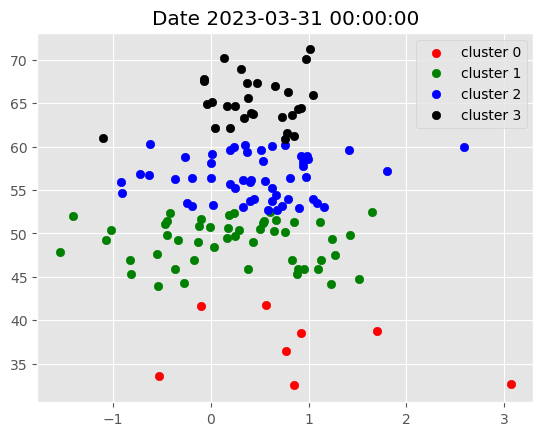

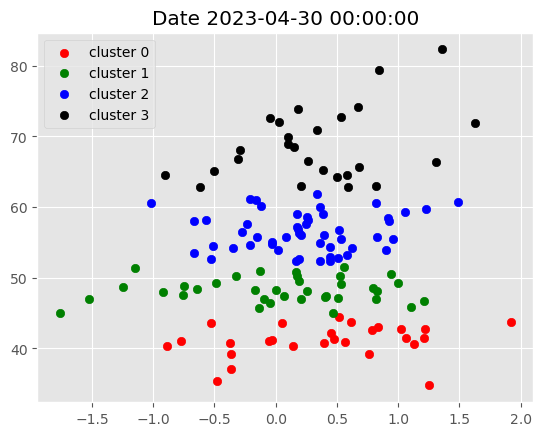

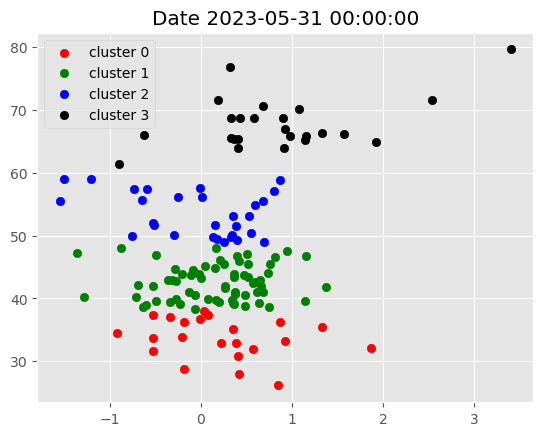

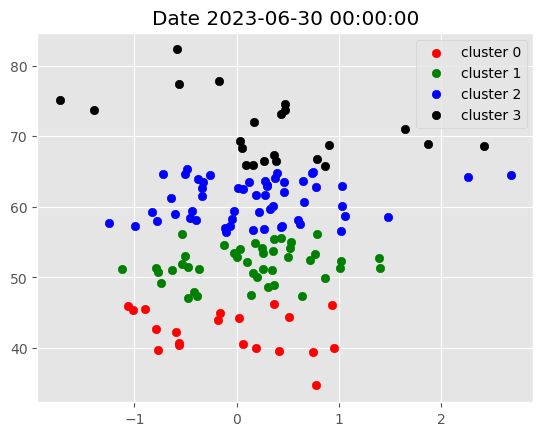

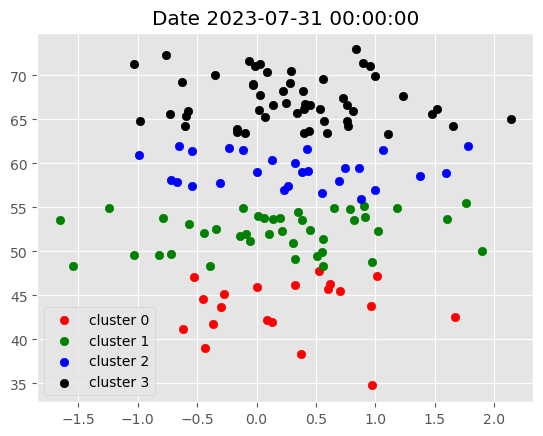

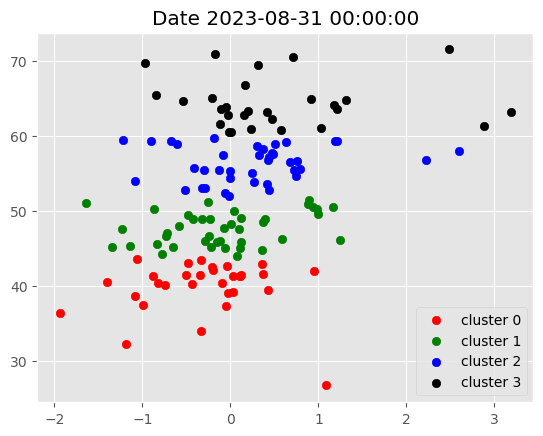

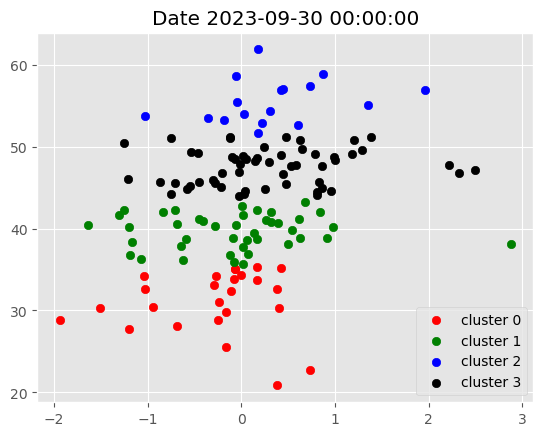

In [52]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

WE WILL APPLY AND DEFINE PRE DEFINED CENTROIDS AS NOT TO SELECT RANDOM CENTROIDS(RANDOM COLOURS WERE APPLIED TO CLUSTER 3 NOW IT IS BLACK)


In [53]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

 For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
 
1)First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

2)Momentum is persistent and our idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus we would select stocks corresponding to cluster 3.

In [54]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['

Define portfolio optimization function

We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

The Sharpe ratio measures the performance of an investment such as a security or portfolio compared to a risk-free asset

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [55]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),#we need 10% thats why we wrote.1
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

Download Fresh Daily Prices Data only for short listed stocks

In [56]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),#we are defining start date as 31/10/2016
                     end=data.index.get_level_values('date').unique()[-1])#end date is 29/09/2023

new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134331   26.248030   40.620968  34.463535  103.970665   
2016-11-01  38.363213   25.774111   41.108887  34.296661  103.881218   
2016-11-02  38.276459   25.797230   41.356487  33.989265  106.090500   
2016-11-03  38.054211   25.520718   40.701088  33.708214  104.605721   
2016-11-04  38.402088   25.290668   40.810314  34.331783  104.856163   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.624237  151.668274  96.467384  314.532135   
2023-09-26  12.700000  171.514893  150.942551  95.240143  308.201630   
2023-09-27  12.610000  169.988846  150.177597  94.547340  311.942383   
2023-09-28  12.920000  170.248184  149.314560  97.110695  298.437927   
2023-09-29  12.810000  170.766846  146.186066  95.853752  304.728760   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   74.257118   72.279999  50.735897   26.654831  ...   
2016-11-01  106.870003   74.137695   70.099998  49.897137   26.489847  ...   
2016-11-02  105.889999   76.747734   68.680000  49.790237   26.205702  ...   
2016-11-03  107.169998   76.193298   67.610001  47.816727   25.912384  ...   
2016-11-04  106.199997   75.980072   69.440002  47.183559   25.866550  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  237.203598  205.669998  61.502777  136.066559  ...   
2023-09-26  506.299988  234.456207  201.660004  60.641556  133.566162  ...   
2023-09-27  502.600006  239.782959  202.279999  60.394081  134.542404  ...   
2023-09-28  504.670013  240.454971  207.889999  60.661354  137.690292  ...   
2023-09-29  509.899994  237.757019  206.910004  59.988220  137.919418  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 930 columns]

Calculate daily returns for each stock which could land up in our portfolio.

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculated each day portfolio return.

In [57]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.001361
2017-11-02,0.002909
2017-11-03,0.006310
2017-11-06,0.003008
2017-11-07,0.002704
...,...
2023-09-25,0.003641
2023-09-26,-0.011470
2023-09-27,0.005189


 Visualize Portfolio returns and compare to SP500 returns.

In [58]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001361,0.001321
2017-11-02,0.002909,0.000389
2017-11-03,0.006310,0.003333
2017-11-06,0.003008,0.001546
2017-11-07,0.002704,-0.000696
...,...,...
2023-09-25,0.003641,0.004196
2023-09-26,-0.011470,-0.014800
2023-09-27,0.005189,0.000399
2023-09-28,0.007977,0.005781


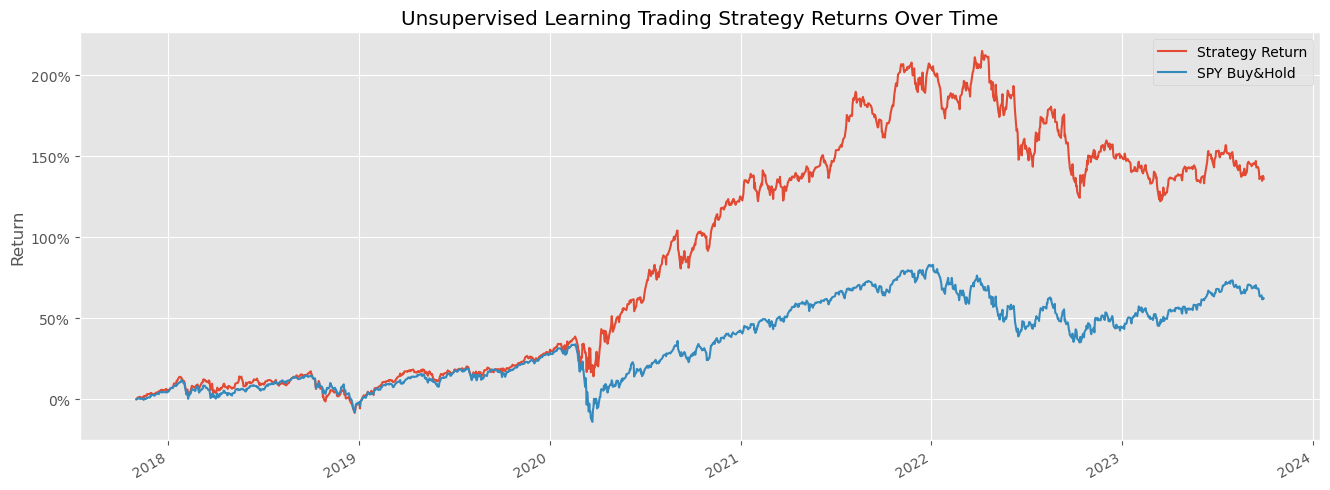

In [59]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

The K-Nearest Neighbors (KNN) algorithm is a straightforward yet powerful tool in Machine Learning, commonly used for regression and classification tasks. It operates by measuring the similarity between data points using a distance function.

In classification, KNN assigns a new data point to the class that has the majority of its nearest neighbors. By adjusting the value of K, the number of nearest neighbors considered, we can impact the accuracy of the classification.

In the trading world, Machine Learning has introduced a paradigm shift, empowering traders to make data-driven decisions and enhancing their strategies. By leveraging historical data and complex algorithms, ML models can identify patterns, predict market movements, and optimise trading approaches.

In [77]:
print(portfolio_df.columns)


Index(['Strategy Return', 'SPY Buy&Hold_x', 'SPY Buy&Hold_y', 'SPY_Buy_Hold_x',
       'SPY_Buy_Hold_y'],
      dtype='object')


In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error



# Features (X) and target variable (y)
X = portfolio_df[['Strategy Return']].values  # Features
y = portfolio_df['SPY Buy&Hold_y'].values  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Creating and fitting the KNN model
k = 3  # Number of neighbors
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)

# Predicting on the test set
y_pred = knn.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.00012363639090812653


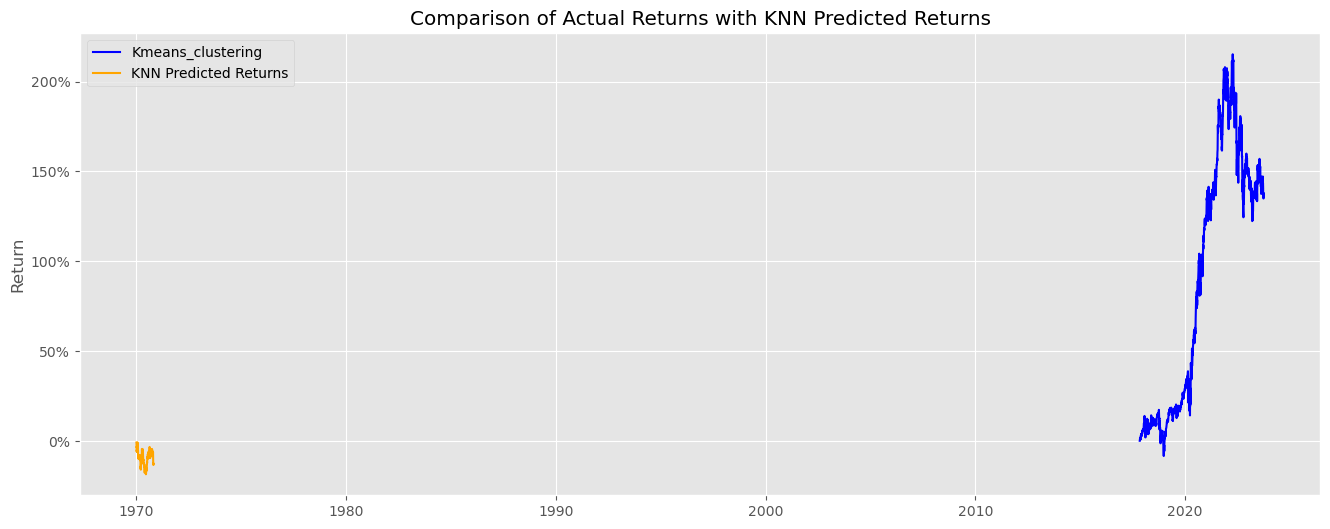

In [91]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
# Plotting the results
plt.figure(figsize=(16, 6))
# Plotting actual returns
portfolio_cumulative_return = (1 + portfolio_df['Strategy Return']).cumprod() - 1
plt.plot(portfolio_cumulative_return['2017-11-01' :'2023-09-29'], label='Kmeans_clustering', color='blue')
# Plotting predicted returns from KNN
portfolio_cumulative_return_knn = (1 + y_pred_knn).cumprod() - 1
plt.plot(portfolio_cumulative_return_knn, label='KNN Predicted Returns', color='orange')
plt.title('Comparison of Actual Returns with KNN Predicted Returns')
plt.ylabel('Return')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.legend()
plt.show()

As you can see in the above image while using KNN we got very large mean square error, and also the returns are negligible so KNN is not a good algorithm for it 

K-Means clustering may cluster loosely related observations together. Every observation becomes a part of some cluster eventually, even if the observations are scattered far away in the vector space. Since clusters depend on the mean value of cluster elements, each data point plays a role in forming the clusters. A slight change in data points might affect the clustering outcome. This problem is greatly reduced in DBSCAN due to the way clusters are formed. This is usually not a big problem unless we come across some odd shape data.

Another challenge with k-means is that you need to specify the number of clusters (“k”) in order to use it. Much of the time, we won’t know what a reasonable k value is a priori.

What’s nice about DBSCAN is that you don’t have to specify the number of clusters to use it. All you need is a function to calculate the distance between values and some guidance for what amount of distance is considered “close”. DBSCAN also produces more reasonable results than k-means across a variety of different distributions

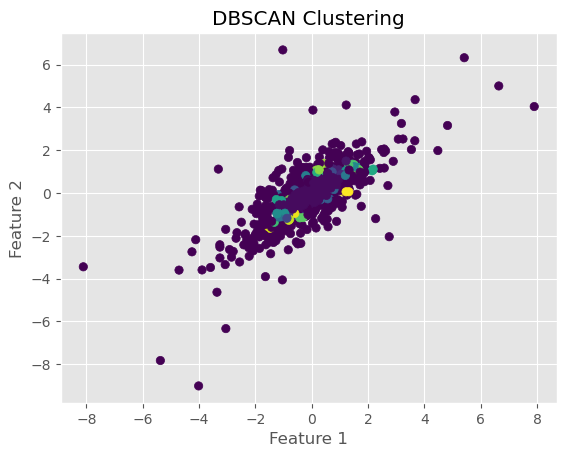

In [97]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming 'portfolio_df' DataFrame is already defined

# Selecting numerical features for clustering
numerical_features = portfolio_df.select_dtypes(include=['float64', 'int64'])



# Scaling the numerical features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(numerical_features)

# DBSCAN model building
# Adjust epsilon (eps) and min_samples parameters as needed
dbscan = DBSCAN(eps=0.1, min_samples=3)
clusters = dbscan.fit_predict(data_scaled)

# Visualizing the clusters (for 2D data)
# Here, I'm assuming you have 2 numerical features
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering')
plt.show()


In the above cluster we can see that the cluster is not proper because all the colours are in the same spot.and not distributed properly


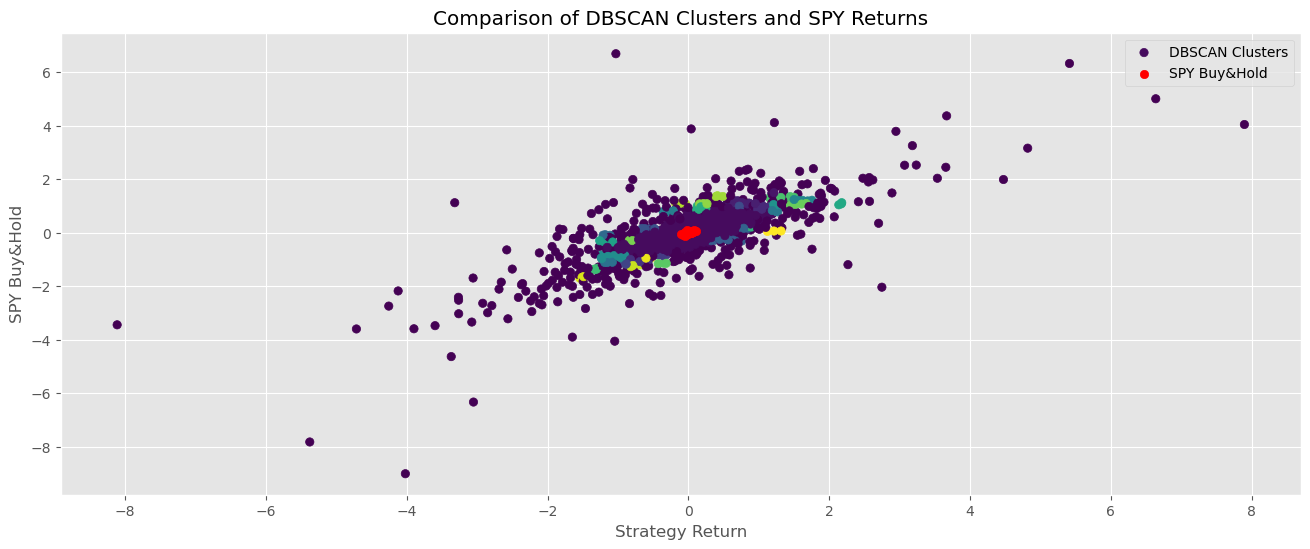

In [103]:
import matplotlib.pyplot as plt

# Plotting the clusters identified by DBSCAN and SPY returns
plt.figure(figsize=(16, 6))

# Plotting DBSCAN clusters
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=clusters, cmap='viridis', label='DBSCAN Clusters')

#plotting spy returns
plt.scatter(portfolio_df['Strategy Return'], portfolio_df['SPY Buy&Hold_y'], c='red', label='SPY Buy&Hold')

plt.xlabel('Strategy Return')
plt.ylabel('SPY Buy&Hold')
plt.title('Comparison of DBSCAN Clusters and SPY Returns')
plt.legend()
plt.show()
